### Importo as Bibiliotecas

In [274]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize
from datetime import datetime
# Para remover os warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Carrego o DataSet para treinamento e teste

In [275]:
#bbdc = yf.download('BBDC',start='2007-02-22',end='2015-02-22')
#bbdc.to_csv('bbdc-train-test.csv')
bbdc = pd.read_csv('bbdc-train-test.csv',sep=',')
bbdc.shape


(2014, 7)

### Crio a função que transforma uma coluna específica em índices do meu DataFrame

In [276]:
def indexing(df,name_column,is_date,date_format):
    if is_date == True:
        df[name_column] = df[name_column].apply(lambda x : datetime.strptime(x,date_format))
    
    df.index = df[name_column]
    return df.copy()


### Faço a indexação do meu DataFrame pela coluna 'Date' e seleciono apenas a coluna 'Close' para trabalhar

In [277]:
bbdc = indexing(bbdc,'Date',True,'%Y-%m-%d')
bbdc = bbdc[['Close','Volume']]
bbdc.tail()

,Close,Volume
Date,,
2015-02-13,22.520000,180500
2015-02-17,22.620001,146700
2015-02-18,22.469999,112300
2015-02-19,22.780001,163600
2015-02-20,23.030001,225200


In [278]:
bbdc.head()

,Close,Volume
Date,,
2007-02-22,15.24,17800
2007-02-23,14.90,48500
2007-02-26,14.57,23800
2007-02-27,14.50,23200
2007-02-28,14.75,12300


### Crio Variáveis Auxiliares

In [279]:
N_ANTERIORES = 5
N_FUTURO = 15
MACD_FAST = N_ANTERIORES
MACD_SLOW = 2 * N_ANTERIORES
MACD_SIGNAL = 1.5 * N_ANTERIORES
SMA_PERIODS = N_ANTERIORES * 5
PERIODS_OBV = N_ANTERIORES


In [280]:
bbdc['Volume'].describe()

count    2.014000e+03
mean     1.321935e+05
std      1.727606e+05
min      0.000000e+00
25%      2.632500e+04
50%      9.810000e+04
75%      1.808750e+05
max      2.701100e+06
Name: Volume, dtype: float64

### Crio Features

In [281]:
bbdc['MACD'] = ta.macd(bbdc['Close'],fast=MACD_FAST,slow=MACD_SLOW,signal=MACD_SIGNAL).iloc[:,0]
bbdc['SMA'] = ta.sma(bbdc['Close'],length=SMA_PERIODS)

from math import log10

bbdc['LOG_OBV'] = ta.obv(bbdc['Close'].apply(log10) , bbdc['Volume'].apply(lambda x : x+1).apply(log10) , length=PERIODS_OBV)
bbdc.drop(columns=['Volume'],inplace=True)

ClosePassado = bbdc['Close'].shift(periods=N_ANTERIORES)
ClosePassado.dropna(axis='index',inplace=True)

bbdc[f'Retorno{N_ANTERIORES}DiasPassados%'] = (bbdc['Close'] - ClosePassado) / ClosePassado


bbdc.dropna(axis='index',inplace=True)


### Crio o Alvo

In [282]:
ClosesFuturo = bbdc['Close'].shift(periods= -N_FUTURO)
bbdc[f'RetornoAlvoProx{N_FUTURO}Dias%'] = (ClosesFuturo - bbdc['Close']) / bbdc['Close']
bbdc = bbdc.dropna(axis=0)
bbdc[f'RetornoAlvoBinProx{N_FUTURO}Dias'] = np.where(bbdc[f'RetornoAlvoProx{N_FUTURO}Dias%'] > 0 , 1 , 0 )


bbdc.drop(columns=[f'RetornoAlvoProx{N_FUTURO}Dias%'],inplace=True)

In [283]:
bbdc.groupby(f'RetornoAlvoBinProx{N_FUTURO}Dias').count()

,Close,MACD,SMA,LOG_OBV,Retorno5DiasPassados%
RetornoAlvoBinProx15Dias,,,,,
0,911,911,911,911,911
1,1064,1064,1064,1064,1064


### Verifico as Correlações entre minhas variáveis com o alvo e entre si

In [284]:
bbdc.corr()

,Close,MACD,SMA,LOG_OBV,Retorno5DiasPassados%,RetornoAlvoBinProx15Dias
Close,1.000000,0.080603,0.992686,0.965615,0.025473,-0.091973
MACD,0.080603,1.000000,-0.034170,0.001594,0.645123,-0.114914
SMA,0.992686,-0.034170,1.000000,0.968675,-0.047077,-0.079276
LOG_OBV,0.965615,0.001594,0.968675,1.000000,-0.013060,-0.048210
Retorno5DiasPassados%,0.025473,0.645123,-0.047077,-0.013060,1.000000,-0.130710
RetornoAlvoBinProx15Dias,-0.091973,-0.114914,-0.079276,-0.048210,-0.130710,1.000000


### Modelagem

In [285]:
bbdc.head()

,Close,MACD,SMA,LOG_OBV,Retorno5DiasPassados%,RetornoAlvoBinProx15Dias
Date,,,,,,
2007-03-28,13.90,-0.113732,14.2556,-24.155721,-0.010676,1
2007-03-29,13.60,-0.125788,14.1900,-28.519351,-0.019466,1
2007-03-30,13.65,-0.117165,14.1400,-24.987745,-0.025000,1
2007-04-02,14.02,-0.049300,14.1180,-21.058275,0.017417,1
2007-04-03,14.10,0.002826,14.1020,-16.812737,0.048327,1


In [286]:
p_test = 0.3

x = bbdc.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias','Close'])
y = bbdc[f'RetornoAlvoBinProx{N_FUTURO}Dias']

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=p_test,random_state=42)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1382, 4) (1382,) (593, 4) (593,)


In [287]:
model_lr = LogisticRegression()
model_lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [288]:
print(x.columns)
model_lr.coef_

Index(['MACD', 'SMA', 'LOG_OBV', 'Retorno5DiasPassados%'], dtype='object')


array([[-1.08899387, -0.18183351,  0.00481936, -1.95813013]])

### Delimito meu ponto de corte na RL e crio a função que vai me ajudar nas previsões com esse novo ponto de corte

In [289]:
cutoff = 0.65
def return_y_pred(x,model,cutoff):
    pred_proba = model.predict_proba(x)[:,1]
    return binarize([pred_proba],cutoff)[0]
        

### Crio minhas duas funções que acumularão os resultados do Trading com a LR e do Buy & Hold

In [290]:
def return_investment_trading(aport_value,X,Closes,model,cutoff,N_FUTURO):
    X['ModelDecision'] = return_y_pred(X,model,cutoff)
    X['RetornoDiaSeguinte%'] = (Closes.shift(-1) - Closes) / Closes
    X.fillna(0.00,inplace=True)
    
    index_buy = -1
    index_sell = -1
    investment_values = [aport_value]
    ops = []

    #percorro todo o dataset linha a linha
    for i in range(X.shape[0]):
        retorno_dia_seguinte_p = X['RetornoDiaSeguinte%'].iloc[i]
        model_decision = X['ModelDecision'].iloc[i]

        #Se o modelo mandou eu comprar e eu não estou posiconado em nenhuma compra anterior
        if model_decision == 1 and i >= index_sell:
            index_buy = i
            index_sell = i + N_FUTURO
            
            #registro como uma operação apenas aquelas onde o indice de venda esta contido nos dados
            if index_sell < X.shape[0]:
                idxb = X.index[index_buy]
                idxs = X.index[index_sell]
                ops.append(dict(index_buy=idxb,index_sell=idxs,
                                profit=(Closes.iloc[index_sell] - Closes.iloc[index_buy])
                                / Closes.iloc[index_buy]))
                
        #Se eu estou no intervalo entre o indice de compra e de venda na operação
        if index_buy <= i <= index_sell:
            
            #Se eu tenho dinheiro suficiente pra colocar um aporte completo na operação
            if investment_values[-1] >= aport_value:
                iv =  investment_values[-1] + (aport_value * retorno_dia_seguinte_p)
            
            #Se não, eu aporto somente o que tenho de caixa disponível
            else:
                iv =  investment_values[-1] + (investment_values[-1] * retorno_dia_seguinte_p)
            
            investment_values.append(iv)
        
        #Se não estou dentro de nenhuma operação aberta anteriormente
        else:
            investment_values.append(investment_values[-1])

    del(investment_values[-1])
    ops = pd.DataFrame(ops)
    
    return pd.DataFrame({'values':investment_values},index=X.index) , ops


def return_investment_buy_and_hold(aport_value,Closes):
    
    qtd_initial_shares = aport_value / Closes.iloc[0]
    values = qtd_initial_shares * Closes
    return pd.DataFrame({'values': values } , index=X.index)


# TREINO

### Verifico métricas do modelo na base de treinamento

In [291]:
y_pred_train_lr = return_y_pred(x_train,model_lr,cutoff)

In [292]:
print('LOGISTIC REGRESSION TRAIN')
print(confusion_matrix(y_train,y_pred_train_lr))
print(classification_report(y_train,y_pred_train_lr))

LOGISTIC REGRESSION TRAIN
[[588  34]
 [651 109]]
              precision    recall  f1-score   support

           0       0.47      0.95      0.63       622
           1       0.76      0.14      0.24       760

    accuracy                           0.50      1382
   macro avg       0.62      0.54      0.44      1382
weighted avg       0.63      0.50      0.42      1382



In [293]:
y_pred_test_lr = return_y_pred(x_test,model_lr,cutoff)

In [294]:
print('LOGISTIC REGRESSION TEST')
print(confusion_matrix(y_test,y_pred_test_lr))
print(classification_report(y_test,y_pred_test_lr))

LOGISTIC REGRESSION TEST
[[269  20]
 [262  42]]
              precision    recall  f1-score   support

           0       0.51      0.93      0.66       289
           1       0.68      0.14      0.23       304

    accuracy                           0.52       593
   macro avg       0.59      0.53      0.44       593
weighted avg       0.59      0.52      0.44       593



### Calculo os resultados do Trading e do Buy & Hold no Treino

In [295]:
aport_value = 1000.00
X = bbdc.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias' , 'Close'])
Closes = bbdc['Close']
TradingResults , ops = return_investment_trading(aport_value=aport_value,X=X,Closes=Closes,model=model_lr,cutoff=cutoff,N_FUTURO=N_FUTURO)

BHResults = return_investment_buy_and_hold(aport_value=aport_value,Closes=Closes)

### Ploto os resultados do Trading e do Buy & Hold na base usada para o treino

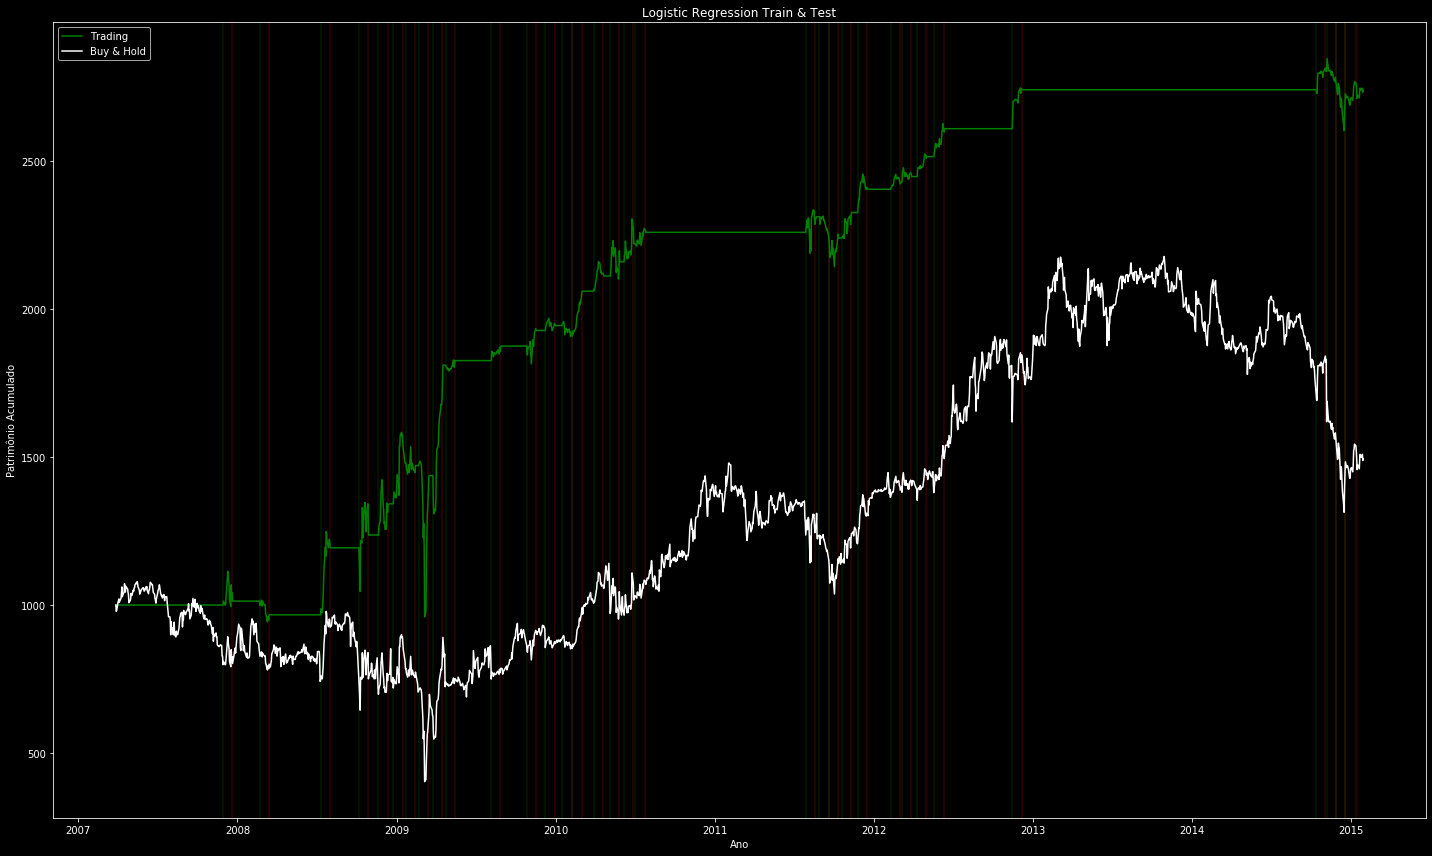

In [296]:
with plt.style.context('dark_background'):
    fig  = plt.figure(figsize=(20,12))
    
    for date in ops[['index_buy','index_sell']].values:
        plt.axvline(date[0],color='green',linewidth=0.3,linestyle='-')
        plt.axvline(date[1],color='red',linewidth=0.3,linestyle='-')
    
    plt.plot(TradingResults,color='green',label='Trading')
    plt.plot(BHResults,color='white',label='Buy & Hold')
    plt.title('Logistic Regression Train & Test')
    plt.xlabel('Ano')
    plt.ylabel('Patrimônio Acumulado')


    plt.legend()
    plt.tight_layout();
    plt.savefig('logistic-regression-train-test.png')

### Verifico o resultado geral do Trading com o modelo e do Buy & Hold

In [297]:
profit_bh = BHResults.iloc[-1] - BHResults.iloc[0]
profit_tr = TradingResults.iloc[-1] - TradingResults.iloc[0]

profit_bh_p = round(profit_bh / BHResults.iloc[0] * 100 , 2)
profit_tr_p = round(profit_tr / TradingResults.iloc[0] * 100 , 2)

print("Profit Buy & Hold:",float(profit_bh_p),'%')
print("Profit Trading:",float(profit_tr_p),'%')

Profit Buy & Hold: 49.5 %
Profit Trading: 173.82 %


# Validação

### Carrego meu DataSet de validação

In [298]:
#bbdc_validation = yf.download('BBDC',start='2015-02-22',end='2020-01-15')
#bbdc_validation.to_csv('bbdc-validation.csv')

bbdc_validation = pd.read_csv('bbdc-validation.csv')
bbdc_validation.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-02-23,23.000000,23.030001,22.780001,23.020000,12.132120,135400
1,2015-02-24,23.020000,23.040001,22.820000,23.000000,12.121583,149700
2,2015-02-25,23.110001,23.340000,22.910000,23.340000,12.300767,163100
3,2015-02-26,23.389999,23.570000,23.110001,23.530001,12.400903,264700
4,2015-02-27,23.629999,23.799999,23.400000,23.670000,12.474685,264800


### Faço a indexação do dataset pela coluna 'Date' e pego a coluna 'Close' pra trabalhar com ela

In [299]:
bbdc_validation = indexing(bbdc_validation,'Date',True,'%Y-%m-%d')
bbdc_validation = bbdc_validation[['Close','Volume']]
bbdc_validation.shape

(1233, 2)

### Crio as Features

In [300]:
bbdc_validation['MACD'] = ta.macd(bbdc_validation['Close'],fast=MACD_FAST,slow=MACD_SLOW,signal=MACD_SIGNAL).iloc[:,0]
bbdc_validation['SMA'] = ta.sma(bbdc_validation['Close'],length=SMA_PERIODS)

from math import log10

bbdc_validation['LOG_OBV'] = ta.obv(bbdc_validation['Close'].apply(log10) , bbdc_validation['Volume'].apply(lambda x : x+1).apply(log10) , length=PERIODS_OBV)
bbdc_validation.drop(columns=['Volume'],inplace=True)

ClosePassado = bbdc_validation['Close'].shift(periods=N_ANTERIORES)
ClosePassado.dropna(axis='index',inplace=True)

bbdc_validation[f'Retorno{N_ANTERIORES}DiasPassados%'] = (bbdc_validation['Close'] - ClosePassado) / ClosePassado


bbdc_validation.dropna(axis='index',inplace=True)
bbdc_validation.shape

(1209, 5)

In [301]:
bbdc_validation.head()

,Close,MACD,SMA,LOG_OBV,Retorno5DiasPassados%
Date,,,,,
2015-03-27,23.020000,-0.068015,23.5576,26.373739,0.006999
2015-03-30,22.860001,-0.103287,23.5512,21.237967,-0.012100
2015-03-31,22.809999,-0.123843,23.5436,16.016812,-0.021030
2015-04-01,23.110001,-0.082095,23.5344,20.984832,-0.010278
2015-04-02,22.959999,-0.077075,23.5116,16.256470,-0.012473


### Crio o Alvo

In [302]:
ClosesFuturo = bbdc_validation['Close'].shift(periods= -N_FUTURO)
bbdc_validation[f'RetornoAlvoProx{N_FUTURO}Dias%'] = (ClosesFuturo - bbdc_validation['Close']) / bbdc_validation['Close']
bbdc_validation = bbdc_validation.dropna(axis=0)
bbdc_validation[f'RetornoAlvoBinProx{N_FUTURO}Dias'] = np.where(bbdc_validation[f'RetornoAlvoProx{N_FUTURO}Dias%'] > 0 , 1 , 0 )
bbdc_validation.drop(columns=[f'RetornoAlvoProx{N_FUTURO}Dias%'],inplace=True)

In [303]:
bbdc_validation.head()

,Close,MACD,SMA,LOG_OBV,Retorno5DiasPassados%,RetornoAlvoBinProx15Dias
Date,,,,,,
2015-03-27,23.020000,-0.068015,23.5576,26.373739,0.006999,1
2015-03-30,22.860001,-0.103287,23.5512,21.237967,-0.012100,1
2015-03-31,22.809999,-0.123843,23.5436,16.016812,-0.021030,1
2015-04-01,23.110001,-0.082095,23.5344,20.984832,-0.010278,1
2015-04-02,22.959999,-0.077075,23.5116,16.256470,-0.012473,1


### Faço as predições

In [304]:
x_validation = bbdc_validation.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias','Close'])
y_validation  = bbdc_validation[f'RetornoAlvoBinProx{N_FUTURO}Dias']

y_pred_validation = return_y_pred(x_validation,model_lr,cutoff)

### Verifico as métricas da Validação

In [305]:
print('LOGISTIC REGRESSION VALIDATION')
print(confusion_matrix(y_validation,y_pred_validation))
print(classification_report(y_validation,y_pred_validation))

LOGISTIC REGRESSION VALIDATION
[[599  24]
 [531  40]]
              precision    recall  f1-score   support

           0       0.53      0.96      0.68       623
           1       0.62      0.07      0.13       571

    accuracy                           0.54      1194
   macro avg       0.58      0.52      0.40      1194
weighted avg       0.58      0.54      0.42      1194



### Comparo Buy & Hold com Trading no Dataset de Validação

In [306]:
aport_value = 1000.00
X = bbdc_validation.drop(columns=[f'RetornoAlvoBinProx{N_FUTURO}Dias' , 'Close'])
Closes = bbdc_validation['Close']
TradingResultsValidation , ops = return_investment_trading(aport_value=aport_value,X=X,Closes=Closes,model=model_lr,cutoff=cutoff,N_FUTURO=N_FUTURO)
BHResultsValidation = return_investment_buy_and_hold(aport_value=aport_value,Closes=Closes)


### Ploto os resultados do Trading e do Buy & Hold no dataset de validação

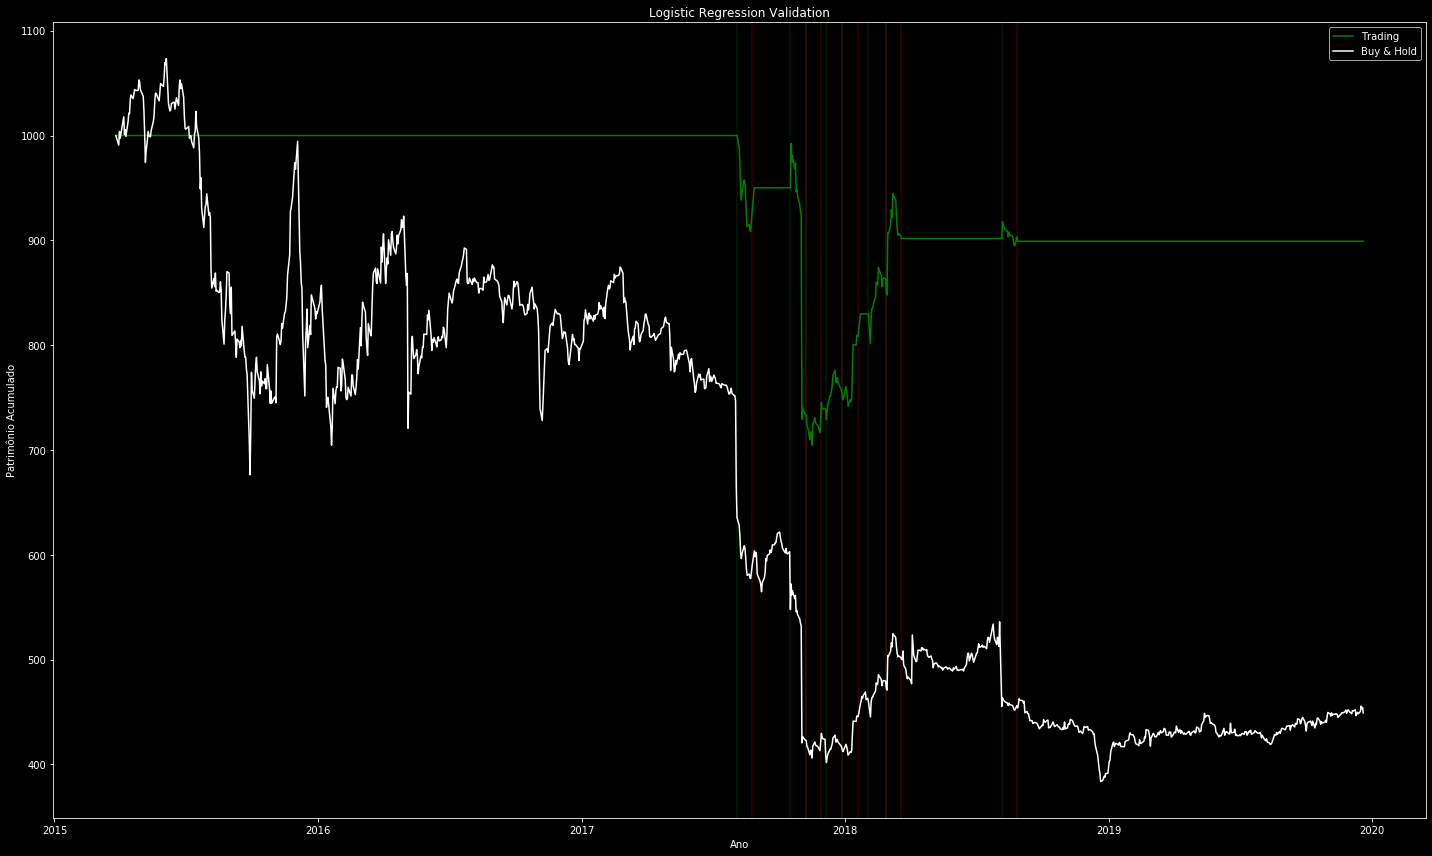

In [307]:
with plt.style.context('dark_background'):
    fig  = plt.figure(figsize=(20,12))
    
    for date in ops[['index_buy','index_sell']].values:
        plt.axvline(date[0],color='green',linewidth=0.3,linestyle='-')
        plt.axvline(date[1],color='red',linewidth=0.3,linestyle='-')
    
    plt.plot(TradingResultsValidation,color='green',label='Trading')
    plt.plot(BHResultsValidation,color='white',label='Buy & Hold')
    plt.title('Logistic Regression Validation')
    plt.xlabel('Ano')
    plt.ylabel('Patrimônio Acumulado')




    plt.legend()
    plt.tight_layout();
    plt.savefig('logistic-regression-validation.png')

### Verifico resultado geral do Trading com o modelo e do Buy & Hold

In [308]:
profit_bh = BHResultsValidation.iloc[-1] - BHResultsValidation.iloc[0]
profit_tr = TradingResultsValidation.iloc[-1] - TradingResultsValidation.iloc[0]

profit_bh_p = round(profit_bh / BHResultsValidation.iloc[0] * 100 , 2)
profit_tr_p = round(profit_tr / TradingResultsValidation.iloc[0] * 100 , 2)

print("Profit Buy & Hold:",float(profit_bh_p),'%')
print("Profit Trading:",float(profit_tr_p),'%')

Profit Buy & Hold: -55.08 %
Profit Trading: -10.09 %


## Analiso o gráfico de resultado financeiro para todo o período de treino + teste + validação

In [309]:
#bbdc_all = yf.download('BBDC' , start='2007-02-22' , end='2020-01-15')
#bbdc_all.to_csv('bbdc-all.csv')

bbdc_all = pd.read_csv('bbdc-all.csv')
bbdc_all.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-02-22,15.25,15.32,15.20,15.24,3.555483,17800
1,2007-02-23,15.30,15.40,14.70,14.90,3.476161,48500
2,2007-02-26,14.98,14.98,14.57,14.57,3.399173,23800
3,2007-02-27,14.57,14.85,14.25,14.50,3.382842,23200
4,2007-02-28,14.50,14.90,14.25,14.75,3.441165,12300


### Faço a indexação do dataset pela coluna 'Date' e pego a coluna 'Close' pra trabalhar com ela

In [310]:
bbdc_all = indexing(bbdc_all,'Date',True,'%Y-%m-%d')
bbdc_all = bbdc_all[['Close','Volume']]
bbdc_all.shape

(3247, 2)

### Crio as Features

In [311]:
bbdc_all['MACD'] = ta.macd(bbdc_all['Close'],fast=MACD_FAST,slow=MACD_SLOW,signal=MACD_SIGNAL).iloc[:,0]
bbdc_all['SMA'] = ta.sma(bbdc_all['Close'],length=SMA_PERIODS)

from math import log10

bbdc_all['LOG_OBV'] = ta.obv(bbdc_all['Close'].apply(log10) , bbdc_all['Volume'].apply(lambda x : x+1).apply(log10) , length=PERIODS_OBV)
bbdc_all.drop(columns=['Volume'],inplace=True)

ClosePassado = bbdc_all['Close'].shift(periods=N_ANTERIORES)
ClosePassado.dropna(axis='index',inplace=True)

bbdc_all[f'Retorno{N_ANTERIORES}DiasPassados%'] = (bbdc_all['Close'] - ClosePassado) / ClosePassado


bbdc_all.dropna(axis='index',inplace=True)
bbdc_all.shape

(3223, 5)

### Comparo Buy & Hold com Trading no Dataset

In [312]:
aport_value = 1000.00
X = bbdc_all.drop(columns=['Close'])
Closes = bbdc_all['Close']
TradingResultsAll , ops = return_investment_trading(aport_value=aport_value,X=X,Closes=Closes,model=model_lr,cutoff=cutoff,N_FUTURO=N_FUTURO)
BHResultsAll = return_investment_buy_and_hold(aport_value=aport_value,Closes=Closes)


### Ploto os resultados do Trading e do Buy & Hold no Dataset

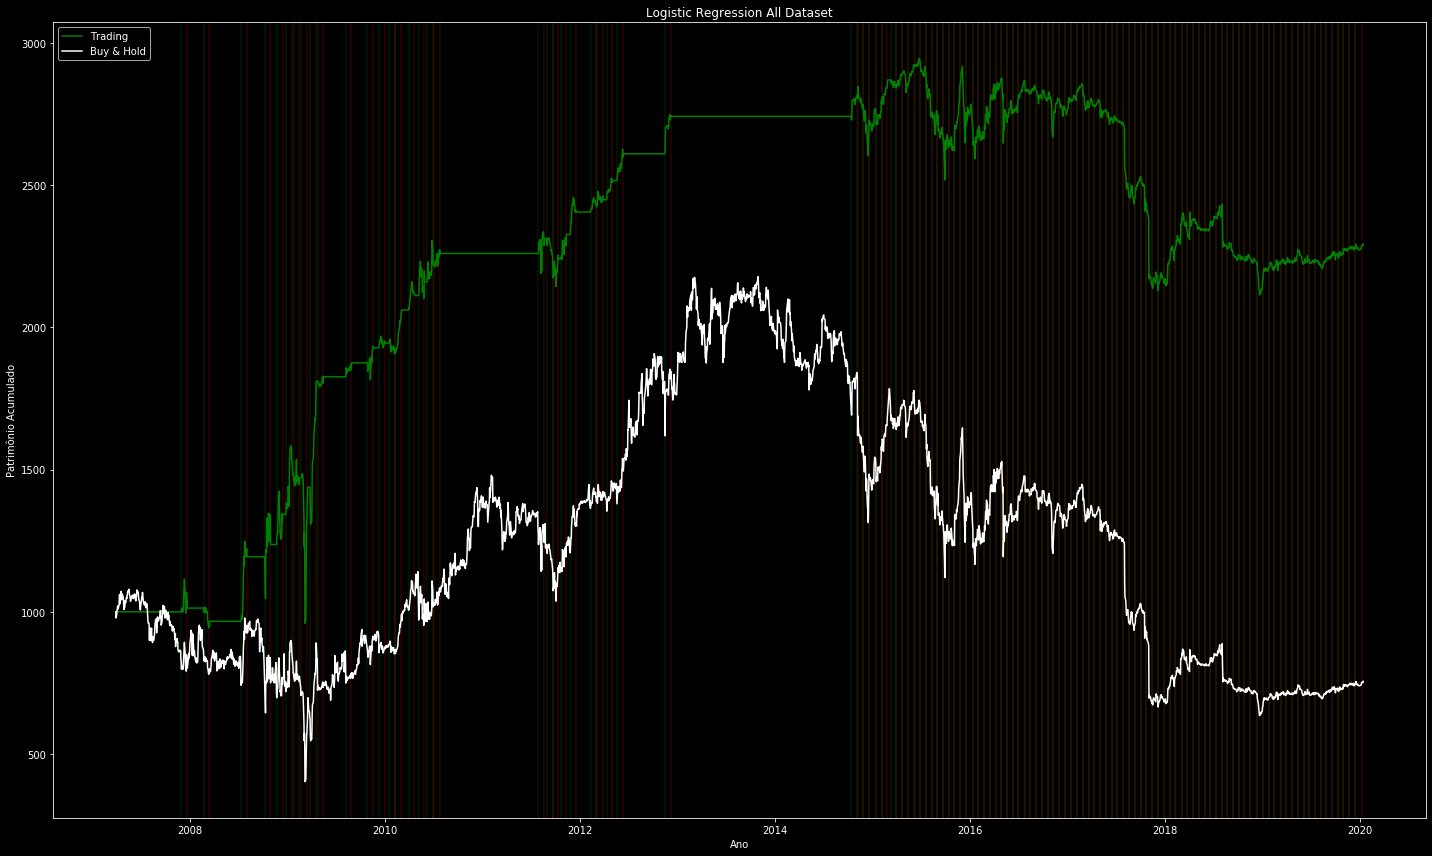

In [313]:
with plt.style.context('dark_background'):
    fig  = plt.figure(figsize=(20,12))
    
    for date in ops[['index_buy','index_sell']].values:
        plt.axvline(date[0],color='green',linewidth=0.3,linestyle='-')
        plt.axvline(date[1],color='red',linewidth=0.3,linestyle='-')
    
    plt.plot(TradingResultsAll,color='green',label='Trading')
    plt.plot(BHResultsAll,color='white',label='Buy & Hold')
    plt.title('Logistic Regression All Dataset')
    plt.xlabel('Ano')
    plt.ylabel('Patrimônio Acumulado')




    plt.legend()
    plt.tight_layout();
    plt.savefig('logistic-regression-train-test-validation.png')

### Verifico resultado financeiro global do modelo

In [314]:
profit_bh = BHResultsAll.iloc[-1] - BHResultsAll.iloc[0]
profit_tr = TradingResultsAll.iloc[-1] - TradingResultsAll.iloc[0]

profit_bh_p = round(profit_bh / BHResultsAll.iloc[0] * 100 , 2)
profit_tr_p = round(profit_tr / TradingResultsAll.iloc[0] * 100 , 2)

print("Profit Buy & Hold:",float(profit_bh_p),'%')
print("Profit Trading:",float(profit_tr_p),'%')

Profit Buy & Hold: -24.46 %
Profit Trading: 129.35 %


## Salvo o modelo treinado, testado e validado

In [315]:
import pickle as pkl

pkl.dump(model_lr,open('model_lr_trading_bbdc.sav','wb'))